In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json


In [5]:
! kaggle datasets download -d prasadvpatil/mrl-dataset

 89% 20.0M/22.6M [00:00<00:00, 45.7MB/s]
100% 22.6M/22.6M [00:00<00:00, 89.8MB/s]


In [6]:
!unzip '/content/mrl-dataset.zip' -d '.'

Archive:  /content/mrl-dataset.zip
  inflating: ./train/Closed_Eyes/s0001_00001_0_0_0_0_0_01.png  
  inflating: ./train/Closed_Eyes/s0001_00002_0_0_0_0_0_01.png  
  inflating: ./train/Closed_Eyes/s0001_00003_0_0_0_0_0_01.png  
  inflating: ./train/Closed_Eyes/s0001_00004_0_0_0_0_0_01.png  
  inflating: ./train/Closed_Eyes/s0001_00005_0_0_0_0_0_01.png  
  inflating: ./train/Closed_Eyes/s0001_00006_0_0_0_0_0_01.png  
  inflating: ./train/Closed_Eyes/s0001_00007_0_0_0_0_0_01.png  
  inflating: ./train/Closed_Eyes/s0001_00008_0_0_0_0_0_01.png  
  inflating: ./train/Closed_Eyes/s0001_00009_0_0_0_0_0_01.png  
  inflating: ./train/Closed_Eyes/s0001_00011_0_0_0_0_0_01.png  
  inflating: ./train/Closed_Eyes/s0001_00013_0_0_0_0_0_01.png  
  inflating: ./train/Closed_Eyes/s0001_00014_0_0_0_0_0_01.png  
  inflating: ./train/Closed_Eyes/s0001_00015_0_0_0_0_0_01.png  
  inflating: ./train/Closed_Eyes/s0001_00016_0_0_0_0_0_01.png  
  inflating: ./train/Closed_Eyes/s0001_00017_0_0_0_0_0_01.png  
  inf

In [38]:
pip install visualkeras

     |████████████████████████████████| 795 kB 10.0 MB/s 


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from keras_visualizer import visualizer 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [10]:
import pathlib
data_dir = '/content/train'
data_dir = pathlib.Path(data_dir)

In [11]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

4000


(138, 138)


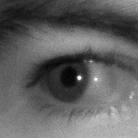

In [12]:
eyeopen = list(data_dir.glob('Open_Eyes/*'))
toast=PIL.Image.open(str(eyeopen[0]))
print(toast.size)
toast

In [13]:
batch_size = 32
img_height = 140
img_width = 140

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4000 files belonging to 2 classes.
Using 3600 files for training.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4000 files belonging to 2 classes.
Using 400 files for validation.


In [16]:
class_names = train_ds.class_names
print(class_names)

['Closed_Eyes', 'Open_Eyes']


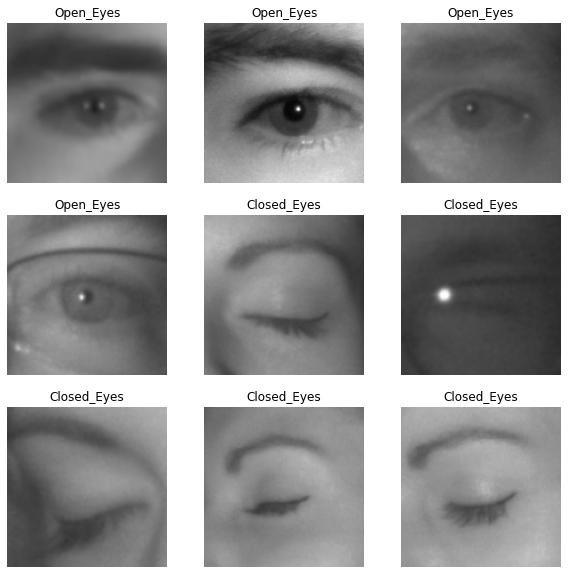

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 140, 140, 3)
(32,)


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [20]:
normalization_layer = layers.Rescaling(1./255)

In [21]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.19656864 1.0


In [22]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

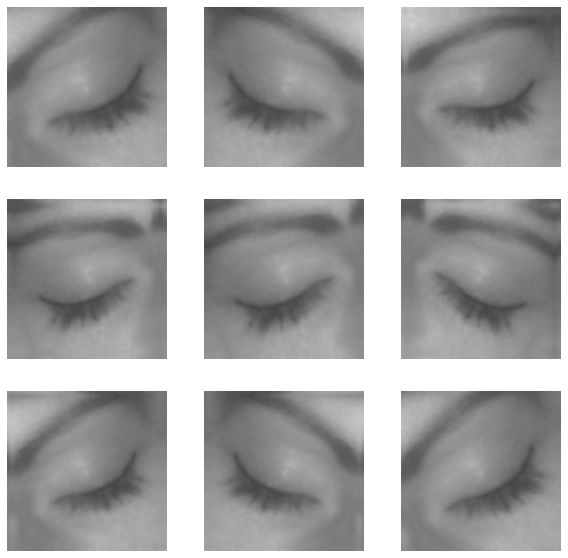

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [39]:
import visualkeras

In [48]:
model3 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(640, activation='relu'),
  layers.Dense(2)
])

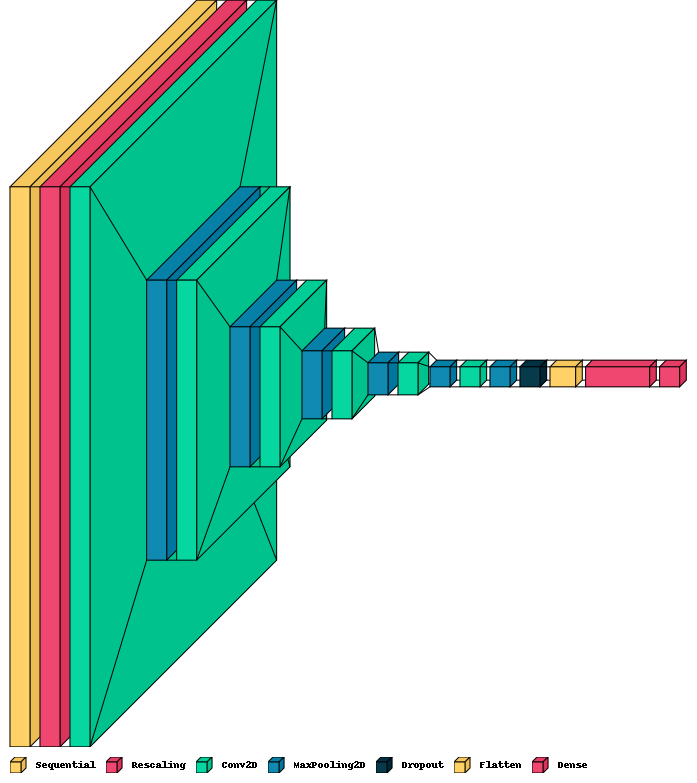

In [49]:
from PIL import ImageFont
visualkeras.layered_view(model3, legend=True)  

In [ ]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 140, 140, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 140, 140, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 140, 140, 16)      1216      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 70, 70, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 70, 70, 32)        12832     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 35, 35, 32)       0         
 2D)                                                  

In [ ]:
epochs0 = 20
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs0
)

Epoch 1/20
113/113 [==============================] - 3s 15ms/step - loss: 0.3715 - accuracy: 0.8050 - val_loss: 0.0704 - val_accuracy: 0.9825
Epoch 2/20
113/113 [==============================] - 2s 14ms/step - loss: 0.0868 - accuracy: 0.9694 - val_loss: 0.0251 - val_accuracy: 0.9925
Epoch 3/20
113/113 [==============================] - 2s 14ms/step - loss: 0.0858 - accuracy: 0.9706 - val_loss: 0.0717 - val_accuracy: 0.9850
Epoch 4/20
113/113 [==============================] - 2s 14ms/step - loss: 0.0533 - accuracy: 0.9828 - val_loss: 0.0452 - val_accuracy: 0.9850
Epoch 5/20
113/113 [==============================] - 2s 14ms/step - loss: 0.0443 - accuracy: 0.9867 - val_loss: 0.0362 - val_accuracy: 0.9900
Epoch 6/20
113/113 [==============================] - 2s 14ms/step - loss: 0.0539 - accuracy: 0.9850 - val_loss: 0.0572 - val_accuracy: 0.9850
Epoch 7/20
113/113 [==============================] - 2s 14ms/step - loss: 0.0364 - accuracy: 0.9897 - val_loss: 0.0341 - val_accuracy: 0.9850

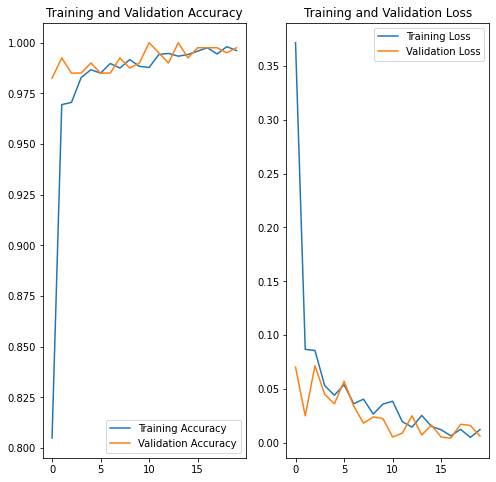

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs0)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
iimg_path = '/content/hypatia-h_f72857758a08235314519c8bb80c8ba4-h_3c0cf60b4f31a5c3dbf59e96b4238175.jpg'

img = tf.keras.utils.load_img(
    iimg_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

#predictions = model3.predict(img_array)
#print(predictions)
predictions = model3.predict(img_array)
print(predictions)
score = tf.nn.softmax(predictions[0])
print(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
     .format(class_names[np.argmax(score)], 100 * np.max(score))
)

[[-7.961054  6.115011]]
tf.Tensor([7.7062356e-07 9.9999928e-01], shape=(2,), dtype=float32)
This image most likely belongs to Open_Eyes with a 100.00 percent confidence.


In [ ]:
model3.save("eyemodel1.h5", save_format='h5')

In [ ]:
new_model = tf.keras.models.load_model('eyemodel1.h5')
new_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 140, 140, 3)       0         
                                                                 
 rescaling_11 (Rescaling)    (None, 140, 140, 3)       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 140, 140, 16)      1216      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 70, 70, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 70, 70, 32)        12832     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 35, 35, 32)       0         
 g2D)                                                 

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model3)
tflite_model = converter.convert()

# Save the model.
with open('eyemodel1.tflite', 'wb') as f:
  f.write(tflite_model)